In [1]:
import numpy as np
import pandas as pd
import pathlib
import string
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer as wordnetlem
import re
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from scipy import sparse
from gensim.models import Word2Vec

In [2]:
pd.set_option('display.max_colwidth', 100)
orig_datapath = pathlib.Path('..') / 'Data'
output_datapath = pathlib.Path('.') / 'Data'
file_fake = 'fake.csv'
file_real = 'real.csv'
df_fake = pd.read_csv(orig_datapath / file_fake)
df_real = pd.read_csv(orig_datapath / file_real)
print(df_fake.head())
print(df_real.head())

                                                                                                 tweet
0  the tongue of his condition, now i saw things that confused you, shame on you, i am not young ha...
1  by god the great, after i saw the derby of wydad and al-raja al-maghribi about the beauty of the...
2  believe in god, this zamalek fans are as good as this, i swear to god\nthey celebrate us or as i...
3  the coach appeared in the media and told the truth.. they got up and told him i swear you are right
4  asno smito\nwhoever knows her tells me a massage, and whoever doesn't know her, leave a comment,...
                                                                                                 tweet
0                                 sun downs technical director: al-ahly respected us and played to win
1                   shawky gharib after the tie with enppi: our goal is to return to the golden square
2  egyptian sports news today, wednesday 1/25/2023, which is many importa

Going to use a column called 'isFake' as the classification target - 1 is for fake news, 0 is for real.

In [3]:
df_fake['isFake'] = 1
df_real['isFake'] = 0
df_tweets = pd.concat([df_fake, df_real], ignore_index = True)

# EDA & Data Cleaning

In [4]:
print(df_tweets.head())
print(df_tweets.tail())
df_tweets.info()

                                                                                                 tweet  \
0  the tongue of his condition, now i saw things that confused you, shame on you, i am not young ha...   
1  by god the great, after i saw the derby of wydad and al-raja al-maghribi about the beauty of the...   
2  believe in god, this zamalek fans are as good as this, i swear to god\nthey celebrate us or as i...   
3  the coach appeared in the media and told the truth.. they got up and told him i swear you are right   
4  asno smito\nwhoever knows her tells me a massage, and whoever doesn't know her, leave a comment,...   

   isFake  
0       1  
1       1  
2       1  
3       1  
4       1  
                                                                                                     tweet  \
41863                      shawky gharib: we excluded 4 players from the current camp list due to injuries   
41864  dina musharraf resumes her career in the singapore table tennis 

All the fake tweets are at the beginning, and real tweets are at the end - we should shuffle the records. Not all algorithms need this, but still. Also, seems like we may have a few null records in tweet column.

In [5]:
df_tweets.isnull().sum()

tweet     17
isFake     0
dtype: int64

Let's remove these, since null tweets are not useful - irrespective of what they are classified as.

In [6]:
df_tweets.dropna(inplace = True)
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41851 entries, 0 to 41867
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   41851 non-null  object
 1   isFake  41851 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 980.9+ KB


Let's check for duplicate records.

In [7]:
df_tweets.duplicated(subset = 'tweet', keep = False).sum()

1564

Seems like we have quiet a few duplicate tweets.

In [8]:
df_tweets[df_tweets.duplicated(subset = 'tweet', keep = False)].sort_values('tweet')

,tweet,isFake
8525,-ittihad -hilal -ahly of the union\nroma is the positive and influential player in al-ittihad...,1
8538,-ittihad -hilal -ahly of the union\nroma is the positive and influential player in al-ittihad...,1
18423,"_ al-ahly _ khaled\noh frogs, oh algae, the only symbol is turki al sheikh\nno other symbol.\ny...",1
7315,"_ al-ahly _ khaled\noh frogs, oh algae, the only symbol is turki al sheikh\nno other symbol.\ny...",1
3324,_ and _ rulers _ for _ insult _ servants\nthe uae federation apologized for hosting the egyptia...,1
...,...,...
23006,"zamalek, in four rounds in the group stage of the champions league, achieved a single victory, a...",0
27173,"zamalek, led by portuguese coach josevaldo ferreira, will conclude his training tomorrow afterno...",0
33386,"zamalek, led by portuguese coach josevaldo ferreira, will conclude his training tomorrow afterno...",0
9501,zidane's reaction to ronaldo's second goal,1


In [9]:
df_tweets.duplicated(subset = 'tweet', keep = 'first').sum()

1027

Let's remove these 1027 records. Also, let me shuffle the data - since we have all the fake tweets at the top and real tweets at the bottom.

In [10]:
df_tweets.drop_duplicates(subset = 'tweet', keep = 'first', inplace = True)
df_tweets = df_tweets.sample(frac = 1, random_state = 76).reset_index(drop = True)
df_tweets.head()

,tweet,isFake
0,"mohamed hassan, the ismaili player, scored the first goal for his team against zamalek in the 3r...",0
1,mido: el-hadary's injury is a great loss.. starting with ghali is a necessity for having a leade...,0
2,"_ audience _ repeats _ the _ symbol\nhaha, the code fails you",1
3,"egypt's first women's team succeeded in qualifying for the 2023 african basketball championship,...",0
4,"smouha club received a letter from the beninese football association, requesting that doku dudu,...",0


In [11]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40824 entries, 0 to 40823
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   40824 non-null  object
 1   isFake  40824 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 638.0+ KB


In [12]:
df_tweets.isFake.value_counts()

isFake
0    21244
1    19580
Name: count, dtype: int64

Looks like a somewhat balanced dataset, now let's clean it (deeply).

# Further Data Cleaning and Feature Extraction

### Tokenization
The tweets we have right now are basically fully formed sentence(s), at least most of them are. Machine Learning algorithms can't deal with sentences (or even words for that matter) - they mostly deal with numbers. As such, we have to somehow translate our sentences to numbers (or a combination of numbers) - and that's easier to do with words or tokens (group of characters representing a useful semantic unit), rather than sentences. Before that we want to rid our sentences of any punctuations or stopwords (a set of commonly used words in any language, like - the, is, and etc. are stopwords in English) - so that we can concentrate solely on the more 'meaningful' words. The following function has been defined to convert these tweets into a list of tokens, and these are the steps it uses to do that -
1) removing punctuations : punctuations being characters, we'll have to look at individual characters of the text string (tweet) to compare it with punctuation symbols (from string package), and then join it back to form a string again.
2) tokenize : splitting the string to separate individual words, which would be needed for the next cleaning steps. We do this using regex package (re) and pattern '\W+' - which treats all non-words (space, -, \ etc.) as separator. output would be list of tokens (words).
3) remove stopwords : in a simlar logic we used for removing punctuations, we'll check each word to see if it's a stopword - we'll get the list of english stopwords from nltk. Probably also worth removing tokens which doesn't contain any character.
4) clubbing similar words : This is done so that similar words (like - read/reading) are grouped together and not considered as separate entities. There are 2 ways this is usually done (a) Stemming - removing suffixes, (b) Lemmatizing - grouping together words identified by the word's lemma (canonical form of a set of words). Stemming is faster, but bit mechanical - for instance, meanness/meaning/mean will all be stemmed to mean. Lemmatizing is a bit smarter, since it considers context and always returns a word that's in the dictionary, but because of that it is slower (computationally expensive) and generally returns more number of words than stemming (which may be correct, given the context). Since our dataset isn't very big, we're going to use lemmatizing.

In [13]:
stopwords_en = stopwords.words('english')
def clean_n_lemmatize(text):
    '''
        cleans and lemmatizes raw text
        input : raw text
        output : cleaned & lemmatized tokens
    '''
    text_nopunct = ''.join([character for character in text.lower() if character not in string.punctuation])
    tokens = re.split('\W+', text_nopunct)
    tokens_no_stop = [word for word in tokens if ((word not in stopwords_en) & (len(word) > 0))]
    lemmatized_tokens = [wordnetlem().lemmatize(word) for word in tokens_no_stop]
    return lemmatized_tokens

In [14]:
df_tweets['tokens'] = df_tweets.tweet.apply(clean_n_lemmatize)
df_tweets.head()

,tweet,isFake,tokens
0,"mohamed hassan, the ismaili player, scored the first goal for his team against zamalek in the 3r...",0,"[mohamed, hassan, ismaili, player, scored, first, goal, team, zamalek, 3rd, minute, match, curre..."
1,mido: el-hadary's injury is a great loss.. starting with ghali is a necessity for having a leade...,0,"[mido, elhadarys, injury, great, loss, starting, ghali, necessity, leader, field]"
2,"_ audience _ repeats _ the _ symbol\nhaha, the code fails you",1,"[audience, repeat, symbol, haha, code, fails]"
3,"egypt's first women's team succeeded in qualifying for the 2023 african basketball championship,...",0,"[egypt, first, woman, team, succeeded, qualifying, 2023, african, basketball, championship, held..."
4,"smouha club received a letter from the beninese football association, requesting that doku dudu,...",0,"[smouha, club, received, letter, beninese, football, association, requesting, doku, dudu, alexan..."


### New Features
Other than the tokens themselves, we can try to derive various other numerical features from these tweets that can be helpful in differentiating between real and fake tweets. Note that we are just trying these out - we'll calculate them and check which of these show clearly distinguished patterns for real and fake tweets. Features that I want to try out -
1) length (without punctuation),
2) token% (length of lemmatized and tokenized words - as a percentage of total length from previous feature),
3) stop% (length of stop words - as a percentage of total length from feature 1),
4) punctuation% (length/count of punctuation - as a percentage of total length, i.e., sum of length from feature 1 and length of punctuation, since length from feature 1 above is sans the punctuation),
5) uppercase% (length/count of uppercase characters - as a percentage of total length from feature 1)

In [15]:
def xtrct_len(text):
    '''
        extract length of text after removing punctuation (before any other cleaning)
        input : unclean text
        output : length of the text (minus punctuation)
    '''
    text_nopunct = ''.join([character for character in text.lower() if character not in string.punctuation])
    return len(text_nopunct)

def xtrct_tokenized_len(token_list):
    '''
        extract sum of length of all the cleaned and lemmatized tokens for each tweet
        input : cleaned tokens
        output : total length (sum) of all the tokens
    '''
    tokenized_length = sum([len(word) for word in token_list])
    return tokenized_length

def xtrct_stop_len(text):
    '''
        extract sum of length of stopwords in text after removing punctuation and tokenizing
        input : unclean text
        output : total length of stopwords in the text
    '''
    text_nopunct = ''.join([character for character in text.lower() if character not in string.punctuation])
    tokens = re.split('\W+', text_nopunct)
    stop_tokens = [word for word in tokens if word in stopwords_en]
    stop_tokens_length = sum([len(stpwrd) for stpwrd in stop_tokens])
    return stop_tokens_length

def xtrct_punct_len(text):
    '''
        extract number of punctuation characters in unclean tweet
        input : unclean tweet
        output : total length of all punctuation in the tweet
    '''
    puncts = [punct for punct in text if punct in string.punctuation]
    return len(puncts)

def xtrct_upper_char_cnt(text):
    '''
        extract number of upper case charatcters in unclean text
        input : unclean text
        output : number of uppercase characters
    '''
    upper_list = re.findall('[A-Z]', text)
    return len(upper_list)

In [16]:
df_tweets['len'] = df_tweets.tweet.apply(xtrct_len)
df_tweets['tok_len'] = df_tweets.tokens.apply(xtrct_tokenized_len)
df_tweets['stp_len'] = df_tweets.tweet.apply(xtrct_stop_len)
df_tweets['punct_cnt'] = df_tweets.tweet.apply(xtrct_punct_len)
df_tweets['upr_cnt'] = df_tweets.tweet.apply(xtrct_upper_char_cnt)
df_tweets.head()

,tweet,isFake,tokens,len,tok_len,stp_len,punct_cnt,upr_cnt
0,"mohamed hassan, the ismaili player, scored the first goal for his team against zamalek in the 3r...",0,"[mohamed, hassan, ismaili, player, scored, first, goal, team, zamalek, 3rd, minute, match, curre...",220,131,51,3,0
1,mido: el-hadary's injury is a great loss.. starting with ghali is a necessity for having a leade...,0,"[mido, elhadarys, injury, great, loss, starting, ghali, necessity, leader, field]",105,61,25,5,0
2,"_ audience _ repeats _ the _ symbol\nhaha, the code fails you",1,"[audience, repeat, symbol, haha, code, fails]",56,33,9,5,0
3,"egypt's first women's team succeeded in qualifying for the 2023 african basketball championship,...",0,"[egypt, first, woman, team, succeeded, qualifying, 2023, african, basketball, championship, held...",150,100,26,6,0
4,"smouha club received a letter from the beninese football association, requesting that doku dudu,...",0,"[smouha, club, received, letter, beninese, football, association, requesting, doku, dudu, alexan...",177,126,24,4,0


Before I proceed with creating the percentage features next, I want to take a separate look at len first - since most of my percentage features will have len as denominator, so I want to ensure that I don't have any 0 len tweets. We have already taken care of null tweets, if there are any remaining tweets with 0 len - that probably contains just punctuation (since, len is the length of the tweet after removing punctuation), and hence not useful.

In [17]:
df_tweets[df_tweets.len == 0]

,tweet,isFake,tokens,len,tok_len,stp_len,punct_cnt,upr_cnt
33580,.,1,[],0,0,0,1,0


We can remove this, since it does not contain any tokens. Probably also worth checking for tweets with tok_len of 0, also indicating no tokens. Our prediction is going to be based on the tokens (the function defined earlier will be the analyzer) - so tweets with no tokens is going to be a problem. Let me see how many of all the (remaining) tweets are like this.

In [18]:
df_tweets[df_tweets.tok_len == 0]

,tweet,isFake,tokens,len,tok_len,stp_len,punct_cnt,upr_cnt
386,what?,1,[],4,0,4,1,0
8288,o...,1,[],1,0,1,3,0
15433,until now,0,[],9,0,8,0,0
32187,a...,1,[],1,0,1,3,0
33580,.,1,[],0,0,0,1,0


The list of these 5 tweets contains at least one real tweet, problem is without any token these are not going to be useful for me. I'm assuming the labeling is correct, and that real tweet could be a reply to another tweet - but since I don't have that context, it's impossible for me to make that distinction. I could still keep these tweets in the set, so that the model might learn how to classify these type of tweets - but based on this set all it's going to learn is that there is 80/20 chance of these being fake, which is biased in it's own way. So, I'm going to drop these.

In [19]:
df_tweets = df_tweets[df_tweets.tok_len > 0]
df_tweets['tok_pct'] = df_tweets.tok_len / df_tweets.len * 100
df_tweets['stp_pct'] = df_tweets.stp_len / df_tweets.len * 100
df_tweets['punct_pct'] = (df_tweets.punct_cnt / (df_tweets.len + df_tweets.punct_cnt)) * 100
df_tweets['upr_pct'] = df_tweets.upr_cnt / df_tweets.len * 100
df_tweets.head()

,tweet,isFake,tokens,len,tok_len,stp_len,punct_cnt,upr_cnt,tok_pct,stp_pct,punct_pct,upr_pct
0,"mohamed hassan, the ismaili player, scored the first goal for his team against zamalek in the 3r...",0,"[mohamed, hassan, ismaili, player, scored, first, goal, team, zamalek, 3rd, minute, match, curre...",220,131,51,3,0,59.545455,23.181818,1.345291,0.0
1,mido: el-hadary's injury is a great loss.. starting with ghali is a necessity for having a leade...,0,"[mido, elhadarys, injury, great, loss, starting, ghali, necessity, leader, field]",105,61,25,5,0,58.095238,23.809524,4.545455,0.0
2,"_ audience _ repeats _ the _ symbol\nhaha, the code fails you",1,"[audience, repeat, symbol, haha, code, fails]",56,33,9,5,0,58.928571,16.071429,8.196721,0.0
3,"egypt's first women's team succeeded in qualifying for the 2023 african basketball championship,...",0,"[egypt, first, woman, team, succeeded, qualifying, 2023, african, basketball, championship, held...",150,100,26,6,0,66.666667,17.333333,3.846154,0.0
4,"smouha club received a letter from the beninese football association, requesting that doku dudu,...",0,"[smouha, club, received, letter, beninese, football, association, requesting, doku, dudu, alexan...",177,126,24,4,0,71.186441,13.559322,2.209945,0.0


### Are all/any of the New Features useful?

Now let's look at these newly minted features. For token, stop, punctuation, and upper - we have both length and percentage features, I'll just explore the percentage features for these.

In [20]:
df_tweets.tok_pct.describe()

count    40819.000000
mean        61.700145
std          9.606203
min         13.043478
25%         55.447891
50%         61.870504
75%         67.567568
max        100.000000
Name: tok_pct, dtype: float64

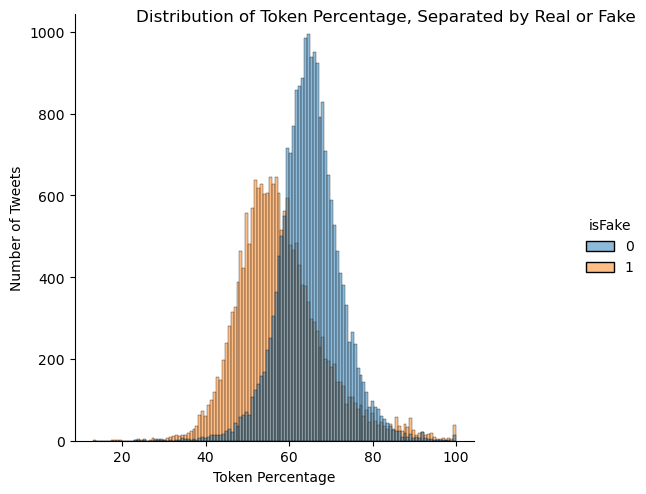

In [21]:
plot = sns.displot(data = df_tweets, x = 'tok_pct', hue = 'isFake')
plot.set_axis_labels('Token Percentage', 'Number of Tweets')
plot.fig.suptitle('Distribution of Token Percentage, Separated by Real or Fake', x = 0.7)
plt.show()
plt.close()

This looks like a useful feature - there is clear distinction between Fake and Not Fake tweets. Looks like the curve for Fake tweets is more spread out. Although the distributions are intersecting - the normal distributions clearly have different mean and standard deviation, hence the 2 curves.

In [22]:
df_tweets.stp_pct.describe()

count    40819.000000
mean        20.433400
std          7.812430
min          0.000000
25%         15.625000
50%         20.179372
75%         25.324675
max         65.217391
Name: stp_pct, dtype: float64

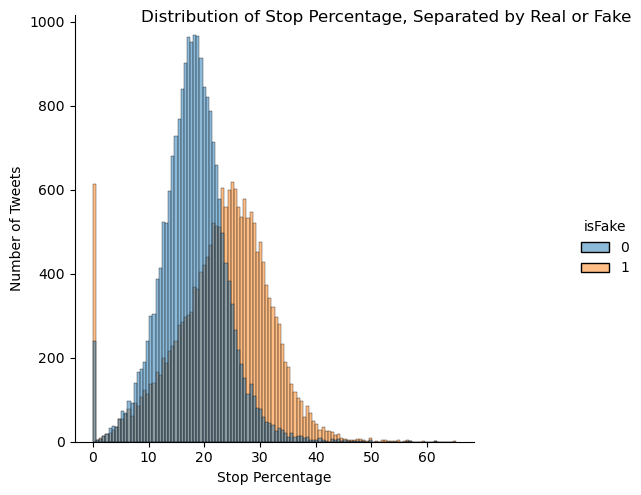

In [23]:
plot = sns.displot(data = df_tweets, x = 'stp_pct', hue = 'isFake')
plot.set_axis_labels('Stop Percentage', 'Number of Tweets')
plot.fig.suptitle('Distribution of Stop Percentage, Separated by Real or Fake', x = 0.7)
plt.show()
plt.close()

In [24]:
df_tweets['punct_pct'].describe()

count    40819.000000
mean         3.506068
std          2.503972
min          0.000000
25%          1.960784
50%          3.061224
75%          4.608295
max         44.444444
Name: punct_pct, dtype: float64

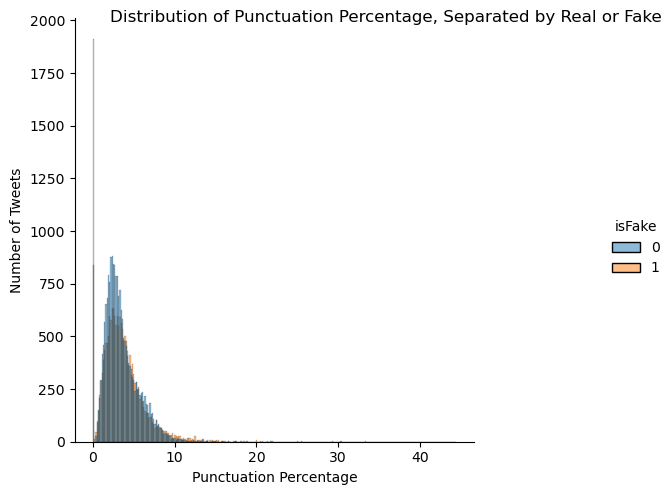

In [25]:
plot = sns.displot(data = df_tweets, x = 'punct_pct', hue = 'isFake')
plot.set_axis_labels('Punctuation Percentage', 'Number of Tweets')
plot.fig.suptitle('Distribution of Punctuation Percentage, Separated by Real or Fake', x = 0.7)
plt.show()
plt.close()

The plot is not very clear. And looks like we have a few not so normal (~30) Punctuation Percent values - let's take a closer look.

In [26]:
df_tweets.query("`punct_pct` >= 30").sort_values('punct_pct')

,tweet,isFake,tokens,len,tok_len,stp_len,punct_cnt,upr_cnt,tok_pct,stp_pct,punct_pct,upr_pct
1590,ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-...,1,[hahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahah...,312,293,13,134,0,93.910256,4.166667,30.044843,0.0
1567,the next coach to be fired is ____________?,1,"[next, coach, fired]",30,14,9,13,0,46.666667,30.000000,30.232558,0.0
34548,ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-...,1,"[hahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahaha, agreement]",90,87,0,39,0,96.666667,0.000000,30.232558,0.0
4624,# (a =)) my stomach) #,1,[stomach],16,7,3,7,0,43.750000,18.750000,30.434783,0.0
24226,ha-ha-ha-ha-ha-ha-ha-ha,1,[hahahahahahahaha],16,16,0,7,0,100.000000,0.000000,30.434783,0.0
35645,ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha,1,[hahahahahahahahahahaha],22,22,0,10,0,100.000000,0.000000,31.250000,0.0
16446,ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha,1,[hahahahahahahahahahahahahahahahaha],34,34,0,16,0,100.000000,0.000000,32.000000,0.0
1849,ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-...,1,[hahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahahaha],86,86,0,42,0,100.000000,0.000000,32.812500,0.0
33044,ha-ha-ha-ha-ha-ha-ha-ha-ha-ha.,1,[hahahahahahahahahaha],20,20,0,10,0,100.000000,0.000000,33.333333,0.0
26607,-ahly.,1,[ahly],4,4,0,2,0,100.000000,0.000000,33.333333,0.0


Can't say that the high punctuation percentage are very justified, but the tweets are not altogether nonsensical - since they still contain some tokens. In hindsight, the ha ha-s should have been tokenized better - looks like by just removing the punctuation, I'm joining hyphenated words. This can mess up meaning of other words as well. Let me see.

In [27]:
df_tweets[(df_tweets.tok_pct > 68) & (df_tweets.stp_pct >= 17)]

,tweet,isFake,tokens,len,tok_len,stp_len,punct_cnt,upr_cnt,tok_pct,stp_pct,punct_pct,upr_pct
467,dardiri says\nthe scavenger hunt will be withdrawn\nout of the league\ni won't continue while it...,1,"[dardiri, say, scavenger, hunt, withdrawn, league, wont, continue, withdrawn, always, used, haha...",168,115,30,2,0,68.452381,17.857143,1.176471,0.0
600,"substituting nunez destroyed the team, imagine this crazy coach, who will supervise the rebuilding",1,"[substituting, nunez, destroyed, team, imagine, crazy, coach, supervise, rebuilding]",96,66,17,2,0,68.750000,17.708333,2.040816,0.0
610,"""percy tao instead of sharif"" .. the formation of the expected al-ahly club against pharco in th...",0,"[percy, tao, instead, sharif, formation, expected, alahly, club, pharco, league, ontimenews, htt...",129,88,22,12,0,68.217054,17.054264,8.510638,0.0
1033,learn about the latest preparations of our national volleyball team before the world championshi...,0,"[learn, latest, preparation, national, volleyball, team, world, championship, ontimenews, httpst...",128,89,22,7,0,69.531250,17.187500,5.185185,0.0
1089,the most prominent preparations of al-ahly club before facing the sudanese crescent in the afric...,0,"[prominent, preparation, alahly, club, facing, sudanese, crescent, african, championship, kohler...",176,120,31,9,0,68.181818,17.613636,4.864865,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
40387,the spanish league begins an investigation into the fact that real madrid player vinicius was su...,0,"[spanish, league, begin, investigation, fact, real, madrid, player, vinicius, subjected, racism,...",176,121,30,7,0,68.750000,17.045455,3.825137,0.0
40506,will the football association resign?,0,"[football, association, resign]",36,25,7,1,0,69.444444,19.444444,2.702703,0.0
40707,the football has entered wellness,1,"[football, entered, wellness]",33,23,6,0,0,69.696970,18.181818,0.000000,0.0
40773,"haha, the referee forgets the mouse. and allied that barcelona maevouz tonight",1,"[haha, referee, forgets, mouse, allied, barcelona, maevouz, tonight]",76,52,13,2,0,68.421053,17.105263,2.564103,0.0


In [28]:
df_tweets[df_tweets.tweet.str.contains('al-ahly\'s')]

,tweet,isFake,tokens,len,tok_len,stp_len,punct_cnt,upr_cnt,tok_pct,stp_pct,punct_pct,upr_pct
40,egypt's ambassador to zambia: al-ahly's mission arrives in lusaka at dawn on friday,0,"[egypt, ambassador, zambia, alahlys, mission, arrives, lusaka, dawn, friday]",79,58,8,4,0,73.417722,10.126582,4.819277,0.0
123,"al-ahly's latest preparations for the sudanese al-hilal match, and who is closest to leading the...",0,"[alahlys, latest, preparation, sudanese, alhilal, match, closest, leading, attack, tomorrow, ont...",138,100,19,11,0,72.463768,13.768116,7.382550,0.0
205,"oh god, half of al-ahly's luck in my life will be my life so",1,"[oh, god, half, alahlys, luck, life, life]",57,28,16,3,0,49.122807,28.070175,5.000000,0.0
277,in the meeting of the football association's board of directors today..the majority agreed to re...,1,"[meeting, football, association, board, director, todaythe, majority, agreed, register, zamalek,...",292,199,45,11,0,68.150685,15.410959,3.630363,0.0
286,"emilio butragueno, director of institutional relations at real madrid, confirmed that al-ahly's ...",0,"[emilio, butragueno, director, institutional, relation, real, madrid, confirmed, alahlys, reachi...",200,131,36,8,0,65.500000,18.000000,3.846154,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
40679,i see a feasible solution to al-ahly's situation\nthey close the club or write it off or cancel ...,1,"[see, feasible, solution, alahlys, situation, close, club, write, cancel, way, encourage, fan, w...",173,97,39,7,0,56.069364,22.543353,3.888889,0.0
40688,al-ahly's match with zamalek is supposed to be like any match in the league. let's not call it t...,1,"[alahlys, match, zamalek, supposed, like, match, league, let, call, alahly, derby, comparable, t...",311,148,100,14,0,47.588424,32.154341,4.307692,0.0
40694,the professional clubs association announced the dates of al-ahly's postponed matches in the lea...,0,"[professional, club, association, announced, date, alahlys, postponed, match, league, competitio...",177,118,28,4,0,66.666667,15.819209,2.209945,0.0
40728,"al-ahly studies zamalek and begins preparing for the summit tomorrow\ntomorrow, wednesday, al-ah...",0,"[alahly, study, zamalek, begin, preparing, summit, tomorrow, tomorrow, wednesday, alahlys, first...",237,162,36,8,0,68.354430,15.189873,3.265306,0.0


In [29]:
df_tweets[df_tweets.tweet.str.contains('-')]

,tweet,isFake,tokens,len,tok_len,stp_len,punct_cnt,upr_cnt,tok_pct,stp_pct,punct_pct,upr_pct
1,mido: el-hadary's injury is a great loss.. starting with ghali is a necessity for having a leade...,0,"[mido, elhadarys, injury, great, loss, starting, ghali, necessity, leader, field]",105,61,25,5,0,58.095238,23.809524,4.545455,0.0
3,"egypt's first women's team succeeded in qualifying for the 2023 african basketball championship,...",0,"[egypt, first, woman, team, succeeded, qualifying, 2023, african, basketball, championship, held...",150,100,26,6,0,66.666667,17.333333,3.846154,0.0
5,the wish of al-ahly account is to mention the eternity account,1,"[wish, alahly, account, mention, eternity, account]",61,39,12,1,0,63.934426,19.672131,1.612903,0.0
7,"the crowd of poverty shouts at the absence of players who include you, they say deliberately, so...",1,"[crowd, poverty, shout, absence, player, include, say, deliberately, alittihad, take, league, pe...",152,87,37,5,0,57.236842,24.342105,3.184713,0.0
8,"when i followed al-ahly, they were feeding haha",1,"[followed, alahly, feeding, haha]",45,25,13,2,0,55.555556,28.888889,4.255319,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
40813,the technical staff of al-tale'a seeks to correct defensive errors and analyze the reasons for d...,0,"[technical, staff, altalea, seek, correct, defensive, error, analyze, reason, defeat, avoid, nex...",185,106,44,4,0,57.297297,23.783784,2.116402,0.0
40814,"no, not after all of this, al-ahly loses, and barcelona loses, haha",1,"[alahly, loses, barcelona, loses, haha]",62,29,22,5,0,46.774194,35.483871,7.462687,0.0
40815,"a well-deserved equalization, honestly but this ruling reminds me of our containment rules",1,"[welldeserved, equalization, honestly, ruling, reminds, containment, rule]",88,60,15,2,0,68.181818,17.045455,2.222222,0.0
40817,"my day was miserable, until i knew that al-ahly was playing tonight.. i laughed at them, haha",1,"[day, miserable, knew, alahly, playing, tonight, laughed, haha]",88,47,25,5,0,53.409091,28.409091,5.376344,0.0


I can see the issues, for instance,  the Al Ahly FC (al-ahly in tweets, and others) have frequently been mentioned as alahly in our tokens. While this is less severe an issue for proper nouns (names, probably preferable even - since these single tokens can directly be earmarked for that particular club), it introduces other issues.

Think about the tweet containing the string "al-ahly's", our tokenizer converts it to alahlys. Our lemmatizer is smart enough to strip the extra 's' from proper nouns - saw somewhere that egypt's has been tokenized as egypt. But our lemmatizer doesn't know that al-ahly should be treated as a proper noun, so the token remains as alahlys. This is a problem because now alahly and alhlys are two separate tokens.

This can be an even bigger issue for non-nouns. Saw that 'well-deserved' has been converted to token welldeserved, there can be many other examples that I have not seen. These type of tokenization is distorting the meaning of the words.

I'm taking a detour now. I'll have to re-do the feature extraction, and then come back to our current task (will have to re-do that from scratch as well, since features will be recreated).

### Tokenization and Feature Extraction (Take 2)

First I need to change the tokenization function, rather than just removing the punctuation - I will replace them with space, which will help with splitting the string (splitting will take care of consecutive spaces, if any, as well).

The functions specific to feature extraction don't need to be redefined, since they don't contribute to token creation. Only tok_len, tok_pct features need to be recreated - since only those were applied on the tokens (others were applied on the tweets directly).

Also, thinking about it now, I want one more feature - count of tokens in the tokenized and lemmatized list.

In [30]:
def clean_n_lemmatize(text):
    '''
        cleans and lemmatizes raw text
        input : raw text
        output : cleaned & lemmatized tokens
    '''
    # text_nopunct = ''.join([character for character in text.lower() if character not in string.punctuation])
    text_nopunct = ''.join([character if character not in string.punctuation else ' ' for character in text.lower()])
    tokens = re.split('\W+', text_nopunct)
    tokens_no_stop = [word for word in tokens if ((word not in stopwords_en) & (len(word) > 0))]
    lemmatized_tokens = [wordnetlem().lemmatize(word) for word in tokens_no_stop]
    return lemmatized_tokens

df_tweets['tokens'] = df_tweets.tweet.apply(clean_n_lemmatize)
df_tweets.head()

,tweet,isFake,tokens,len,tok_len,stp_len,punct_cnt,upr_cnt,tok_pct,stp_pct,punct_pct,upr_pct
0,"mohamed hassan, the ismaili player, scored the first goal for his team against zamalek in the 3r...",0,"[mohamed, hassan, ismaili, player, scored, first, goal, team, zamalek, 3rd, minute, match, curre...",220,131,51,3,0,59.545455,23.181818,1.345291,0.0
1,mido: el-hadary's injury is a great loss.. starting with ghali is a necessity for having a leade...,0,"[mido, el, hadary, injury, great, loss, starting, ghali, necessity, leader, field]",105,61,25,5,0,58.095238,23.809524,4.545455,0.0
2,"_ audience _ repeats _ the _ symbol\nhaha, the code fails you",1,"[audience, repeat, symbol, haha, code, fails]",56,33,9,5,0,58.928571,16.071429,8.196721,0.0
3,"egypt's first women's team succeeded in qualifying for the 2023 african basketball championship,...",0,"[egypt, first, woman, team, succeeded, qualifying, 2023, african, basketball, championship, held...",150,100,26,6,0,66.666667,17.333333,3.846154,0.0
4,"smouha club received a letter from the beninese football association, requesting that doku dudu,...",0,"[smouha, club, received, letter, beninese, football, association, requesting, doku, dudu, alexan...",177,126,24,4,0,71.186441,13.559322,2.209945,0.0


In [31]:
df_tweets['tok_len'] = df_tweets.tokens.apply(xtrct_tokenized_len)
# not needed, since these are applied on the tweets directly - irrespective of how tokens are being created
# df_tweets['len'] = df_tweets.tweet.apply(xtrct_len)
# df_tweets['stp_len'] = df_tweets.tweet.apply(xtrct_stop_len)
# df_tweets['punct_cnt'] = df_tweets.tweet.apply(xtrct_punct_len)
# df_tweets['upr_cnt'] = df_tweets.tweet.apply(xtrct_upper_char_cnt)

# new feature
df_tweets['tok_cnt'] = df_tweets.tokens.apply(len)

df_tweets[df_tweets.tok_len < 4]
# rechecking whether there are any records with small tok_len
# not expecting any with tok_len = 0 - since, already removed a few tweets for that reason

,tweet,isFake,tokens,len,tok_len,stp_len,punct_cnt,upr_cnt,tok_pct,stp_pct,punct_pct,upr_pct,tok_cnt
9146,sh.,1,[sh],2,2,0,1,0,100.000000,0.000000,33.333333,0.0,1
12810,", woe to you only",1,[woe],16,3,9,1,0,18.750000,56.250000,5.882353,0.0,1
17215,ahh,1,[ahh],4,3,0,0,0,75.000000,0.000000,0.000000,0.0,1
22717,1-0,0,"[1, 0]",2,2,0,1,0,100.000000,0.000000,33.333333,0.0,2
29178,what are you guys doing?,1,[guy],23,3,15,1,0,13.043478,65.217391,4.166667,0.0,1
37345,law above all,0,[law],13,3,8,0,0,23.076923,61.538462,0.000000,0.0,1
37879,men did it,0,[men],10,3,5,0,0,30.000000,50.000000,0.000000,0.0,1
38778,they got up,1,[got],11,3,6,0,0,27.272727,54.545455,0.000000,0.0,1


In [32]:
df_tweets['tok_pct'] = df_tweets.tok_len / df_tweets.len * 100
# df_tweets['stp_pct'] = df_tweets.stp_len / df_tweets.len * 100
# df_tweets['punct_pct'] = (df_tweets.punct_cnt / (df_tweets.len + df_tweets.punct_cnt)) * 100
# df_tweets['upr_pct'] = df_tweets.upr_cnt / df_tweets.len * 100
df_tweets.head()

,tweet,isFake,tokens,len,tok_len,stp_len,punct_cnt,upr_cnt,tok_pct,stp_pct,punct_pct,upr_pct,tok_cnt
0,"mohamed hassan, the ismaili player, scored the first goal for his team against zamalek in the 3r...",0,"[mohamed, hassan, ismaili, player, scored, first, goal, team, zamalek, 3rd, minute, match, curre...",220,131,51,3,0,59.545455,23.181818,1.345291,0.0,22
1,mido: el-hadary's injury is a great loss.. starting with ghali is a necessity for having a leade...,0,"[mido, el, hadary, injury, great, loss, starting, ghali, necessity, leader, field]",105,60,25,5,0,57.142857,23.809524,4.545455,0.0,11
2,"_ audience _ repeats _ the _ symbol\nhaha, the code fails you",1,"[audience, repeat, symbol, haha, code, fails]",56,33,9,5,0,58.928571,16.071429,8.196721,0.0,6
3,"egypt's first women's team succeeded in qualifying for the 2023 african basketball championship,...",0,"[egypt, first, woman, team, succeeded, qualifying, 2023, african, basketball, championship, held...",150,100,26,6,0,66.666667,17.333333,3.846154,0.0,16
4,"smouha club received a letter from the beninese football association, requesting that doku dudu,...",0,"[smouha, club, received, letter, beninese, football, association, requesting, doku, dudu, alexan...",177,126,24,4,0,71.186441,13.559322,2.209945,0.0,19


### Feature Exploration (or, Are all/any of the New Features useful? - Take 2)

We had already analyzed tok_pct, stp_pct, and were in the middle of analyzing punct _pct. We have to reanalyze tok_pct, and continue with punct_pct.

In [33]:
df_tweets.tok_pct.describe()

count    40819.000000
mean        61.236960
std          9.608965
min         13.043478
25%         54.954955
50%         61.563518
75%         67.187500
max        100.000000
Name: tok_pct, dtype: float64

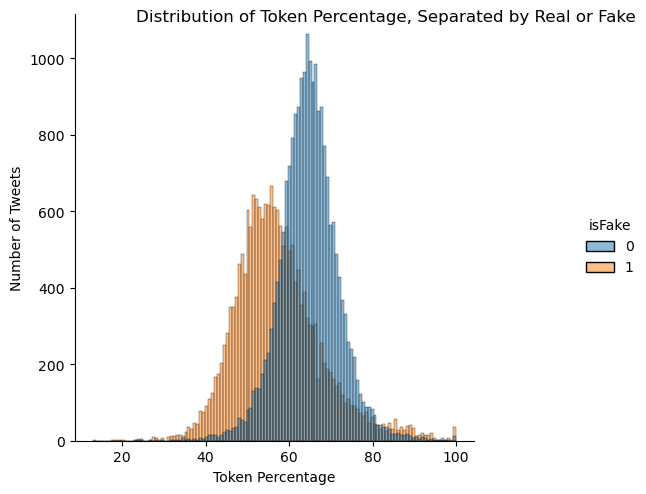

In [34]:
plot = sns.displot(data = df_tweets, x = 'tok_pct', hue = 'isFake')
plot.set_axis_labels('Token Percentage', 'Number of Tweets')
plot.fig.suptitle('Distribution of Token Percentage, Separated by Real or Fake', x = 0.7)
plt.show()
plt.close()

In [35]:
df_tweets['punct_pct'].describe()

count    40819.000000
mean         3.506068
std          2.503972
min          0.000000
25%          1.960784
50%          3.061224
75%          4.608295
max         44.444444
Name: punct_pct, dtype: float64

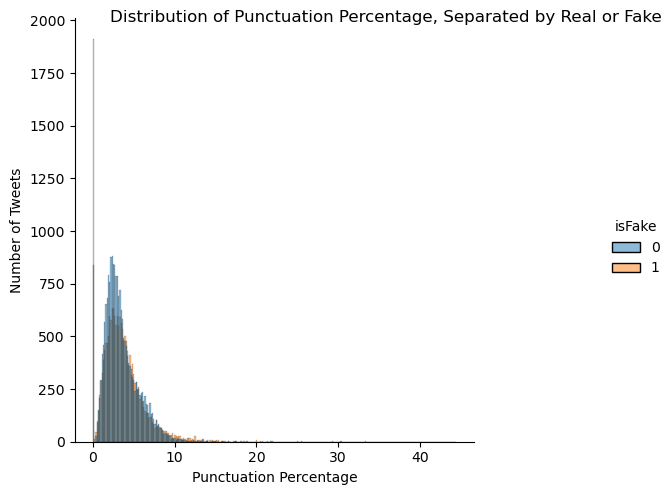

In [36]:
plot = sns.displot(data = df_tweets, x = 'punct_pct', hue = 'isFake')
plot.set_axis_labels('Punctuation Percentage', 'Number of Tweets')
plot.fig.suptitle('Distribution of Punctuation Percentage, Separated by Real or Fake', x = 0.7)
plt.show()
plt.close()

punct_pct hasn't changed (of course) - there is not a lot that can be understood from this plot. Let me try to 'zoom in' to the punct_pct values limited to 15 (the plot sort of plateaus after that).

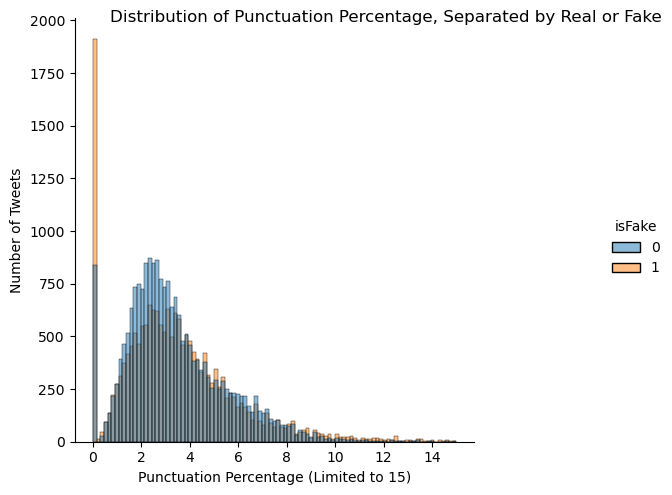

In [37]:
plot = sns.displot(data = df_tweets[df_tweets['punct_pct'] <= 15], x = 'punct_pct', hue = 'isFake')
plot.set_axis_labels('Punctuation Percentage (Limited to 15)', 'Number of Tweets')
plot.fig.suptitle('Distribution of Punctuation Percentage, Separated by Real or Fake', x = 0.7)
plt.show()
plt.close()

When we discount the more extreme values the plot becomes actually clear. There is very little to distinguish between real and fake tweets by looking at this feature - this doesn't look very useful.

In [38]:
df_tweets.upr_pct.describe()

count    40819.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: upr_pct, dtype: float64

In [39]:
max(df_tweets.upr_cnt)

0

uppr_pct (and uppr_cnt) is always 0, which means none of the tweets contain any upper case characters. So, these features are not going to be useful.

In [40]:
df_tweets.len.describe()

count    40819.000000
mean       154.717778
std         86.848716
min          2.000000
25%         87.000000
50%        147.000000
75%        204.000000
max        674.000000
Name: len, dtype: float64

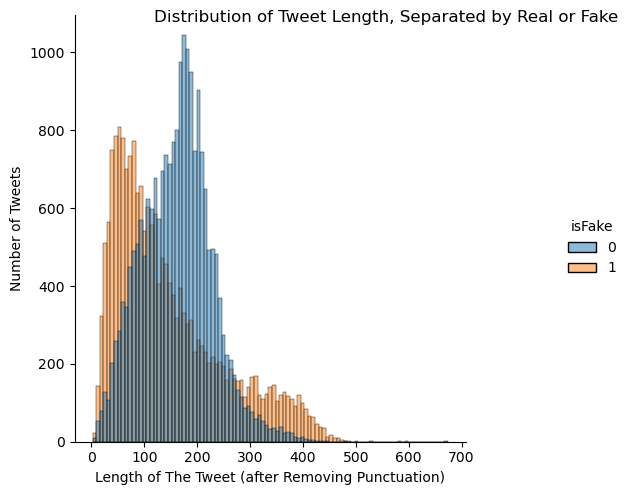

In [41]:
plot = sns.displot(data = df_tweets, x = 'len', hue = 'isFake')
plot.set_axis_labels('Length of The Tweet (after Removing Punctuation)', 'Number of Tweets')
plot.fig.suptitle('Distribution of Tweet Length, Separated by Real or Fake', x = 0.7)
plt.show()
plt.close()

In [42]:
df_tweets.tok_cnt.describe()

count    40819.000000
mean        16.307553
std          8.576043
min          1.000000
25%         10.000000
50%         16.000000
75%         22.000000
max        153.000000
Name: tok_cnt, dtype: float64

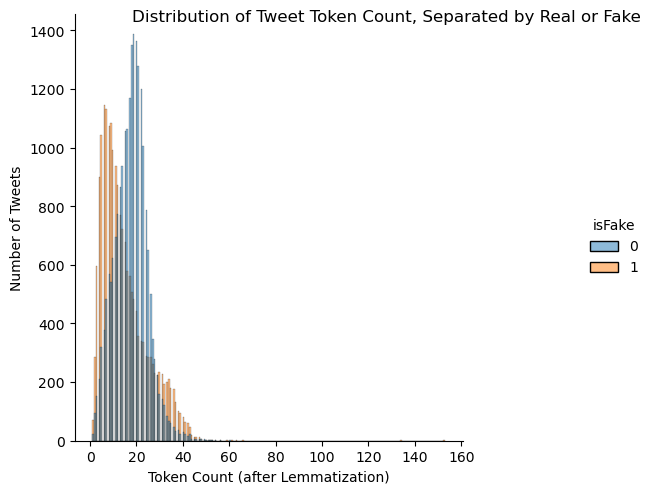

In [43]:
plot = sns.displot(data = df_tweets, x = 'tok_cnt', hue = 'isFake')
plot.set_axis_labels('Token Count (after Lemmatization)', 'Number of Tweets')
plot.fig.suptitle('Distribution of Tweet Token Count, Separated by Real or Fake', x = 0.7)
plt.show()
plt.close()

The almost overlapping distributions don't really leave a lot of room for distinction between real and fake tweets. There are some tweets with tok_count in the outliers, let me take a look there - but overall I'm not very excited about this feature.

In [44]:
df_tweets[df_tweets.tok_cnt > 50]

,tweet,isFake,tokens,len,tok_len,stp_len,punct_cnt,upr_cnt,tok_pct,stp_pct,punct_pct,upr_pct,tok_cnt
1590,ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-ha-...,1,"[ha, ha, ha, ha, ha, ha, ha, ha, ha, ha, ha, ha, ha, ha, ha, ha, ha, ha, ha, ha, ha, ha, ha, ha,...",312,287,13,134,0,91.987179,4.166667,30.044843,0.0,134
9487,referees of tuesday's matches within the 7th round of the league\narmy x ismaili: mahmoud al-ban...,0,"[referee, tuesday, match, within, 7th, round, league, army, x, ismaili, mahmoud, al, banna, must...",365,282,23,17,0,77.260274,6.301370,4.450262,0.0,51
9756,the names of the referees for the two matches on tuesday in the 28th round:\nal-assiouti and enp...,0,"[name, referee, two, match, tuesday, 28th, round, al, assiouti, enppi, mahmoud, bassiouni, assis...",422,296,53,14,0,70.142180,12.559242,3.211009,0.0,52
9776,"ladies and gentlemen,\nhere is the list of teams that removed 3 from al-ahly in the various tour...",1,"[lady, gentleman, list, team, removed, 3, al, ahly, various, tournament, season, al, ahly, 3, 0,...",275,187,33,25,0,68.000000,12.000000,8.333333,0.0,51
10018,"in the first round of the premier league for women's football, the media players defeated ali ka...",0,"[first, round, premier, league, woman, football, medium, player, defeated, ali, kafr, saad, 7, 0...",339,240,40,20,0,70.796460,11.799410,5.571031,0.0,56
11504,-ahly_union al-ahly is a problem. it says al-ittihad's victory over al-ahly in the championship....,1,"[ahly, union, al, ahly, problem, say, al, ittihad, victory, al, ahly, championship, haha, take, ...",314,222,28,26,0,70.700637,8.917197,7.647059,0.0,52
13154,referees for thursday's matches in round 6 of the premier league\nismaili x enppi: muhammad al-s...,0,"[referee, thursday, match, round, 6, premier, league, ismaili, x, enppi, muhammad, al, sabahi, h...",362,275,26,20,0,75.966851,7.182320,5.235602,0.0,53
16006,ha-ha-ha-ha-ha-ha-ha-ha-ha-ha\nha-ha-ha-ha-ha-ha-ha-ha\nha-ha-ha-ha-ha-ha\nhahahahahahaha\nhahah...,1,"[ha, ha, ha, ha, ha, ha, ha, ha, ha, ha, ha, ha, ha, ha, ha, ha, ha, ha, ha, ha, ha, ha, ha, ha,...",294,263,5,44,0,89.455782,1.700680,13.017751,0.0,66
16658,"today, the republic championship, born in 2003, was launched, where al-nujoum defeated al-hodoud...",0,"[today, republic, championship, born, 2003, launched, al, nujoum, defeated, al, hodoud, 2, 1, sm...",307,227,29,24,0,73.941368,9.446254,7.250755,0.0,52
16715,"the results of the 21st round of the 97-born league: pyramids defeated al-dakhiliya 3-1, tala'a ...",0,"[result, 21st, round, 97, born, league, pyramid, defeated, al, dakhiliya, 3, 1, tala, al, jaish,...",306,227,29,27,0,74.183007,9.477124,8.108108,0.0,56


As discussed so far - we can remove tok_len, stp_len, punct_cnt, upr_cnt, punct_pct, upr_pct features. tok_cnt doesn't look useful directly, but it might be of some use while we try to vectorize the tokens.

In [45]:
df_tweets.drop(columns = ['tok_len', 'stp_len', 'punct_cnt', 'upr_cnt', 'punct_pct', 'upr_pct'], inplace = True)
df_tweets.head()

,tweet,isFake,tokens,len,tok_pct,stp_pct,tok_cnt
0,"mohamed hassan, the ismaili player, scored the first goal for his team against zamalek in the 3r...",0,"[mohamed, hassan, ismaili, player, scored, first, goal, team, zamalek, 3rd, minute, match, curre...",220,59.545455,23.181818,22
1,mido: el-hadary's injury is a great loss.. starting with ghali is a necessity for having a leade...,0,"[mido, el, hadary, injury, great, loss, starting, ghali, necessity, leader, field]",105,57.142857,23.809524,11
2,"_ audience _ repeats _ the _ symbol\nhaha, the code fails you",1,"[audience, repeat, symbol, haha, code, fails]",56,58.928571,16.071429,6
3,"egypt's first women's team succeeded in qualifying for the 2023 african basketball championship,...",0,"[egypt, first, woman, team, succeeded, qualifying, 2023, african, basketball, championship, held...",150,66.666667,17.333333,16
4,"smouha club received a letter from the beninese football association, requesting that doku dudu,...",0,"[smouha, club, received, letter, beninese, football, association, requesting, doku, dudu, alexan...",177,71.186441,13.559322,19


Let me take a quick look at the overall distributions (without the real/fake separation this time) of the remaining newly created numerical features.

<Axes: xlabel='stp_pct', ylabel='Count'>

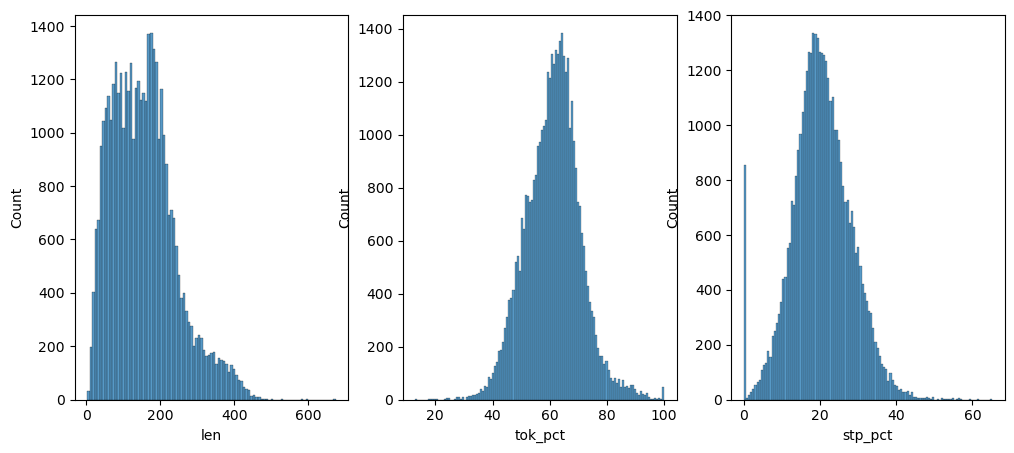

In [46]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = (12, 5))
sns.histplot(data = df_tweets, x = 'len', ax = ax1)
sns.histplot(data = df_tweets, x = 'tok_pct', ax = ax2)
sns.histplot(data = df_tweets, x = 'stp_pct', ax = ax3)

We'll use tree based and non-tree based classification methods on this data. We'll use Scaled/Standardized numerical features so that all classification methods work on the same dataset.

stp_pct, tok_pct look normally distributed, just need scaling. But length is right-skewed, not normalized. To somewhat normalize it, we'll try Box-Cox Transformation.

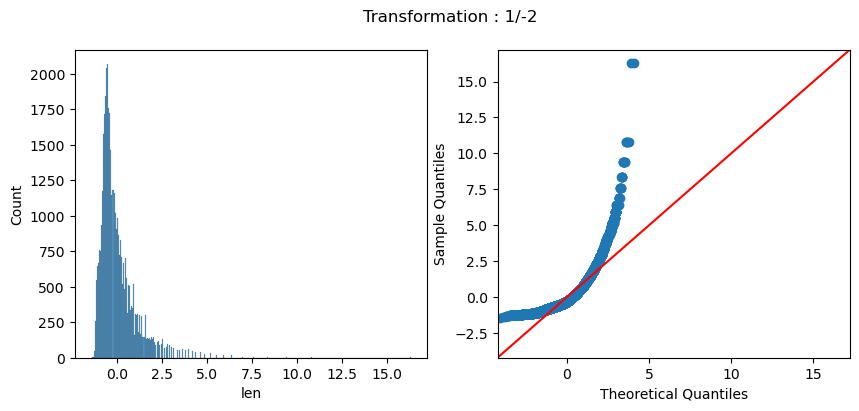

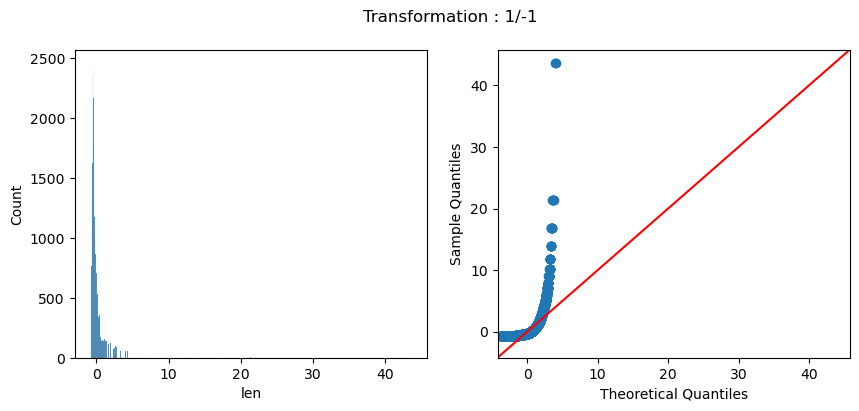

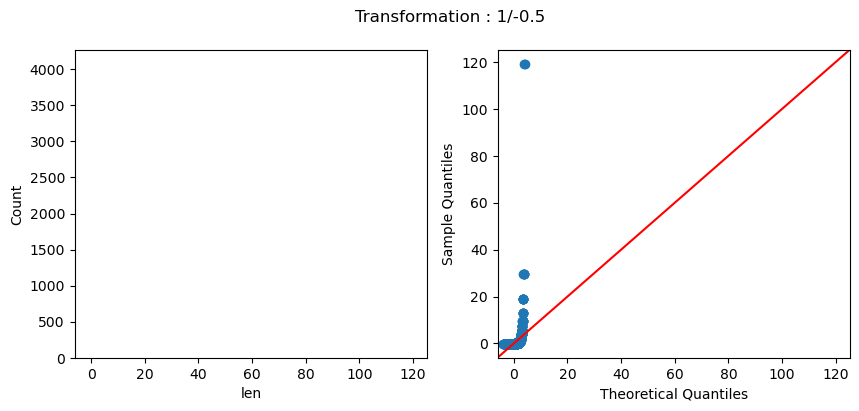

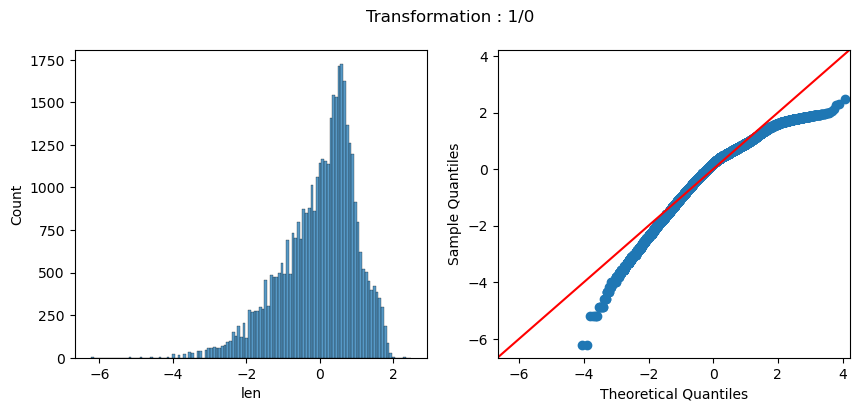

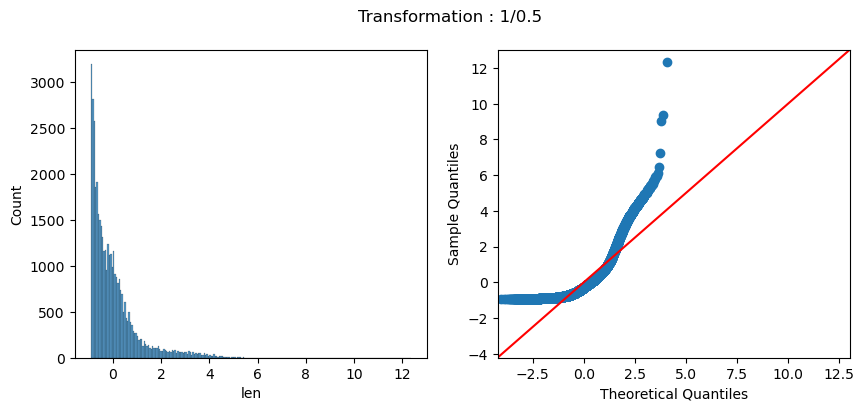

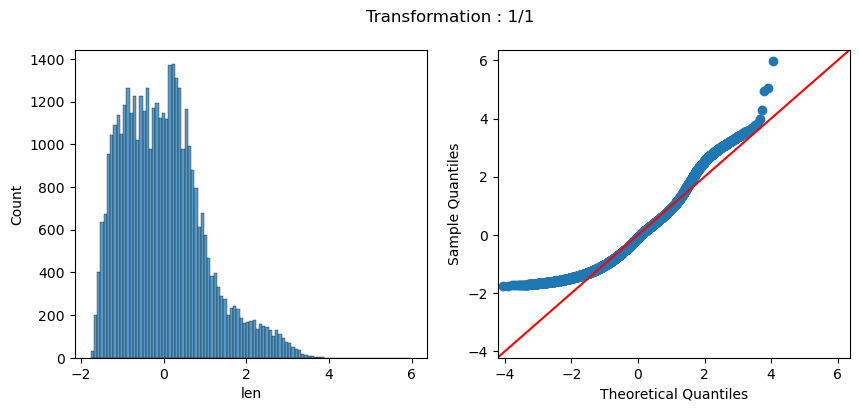

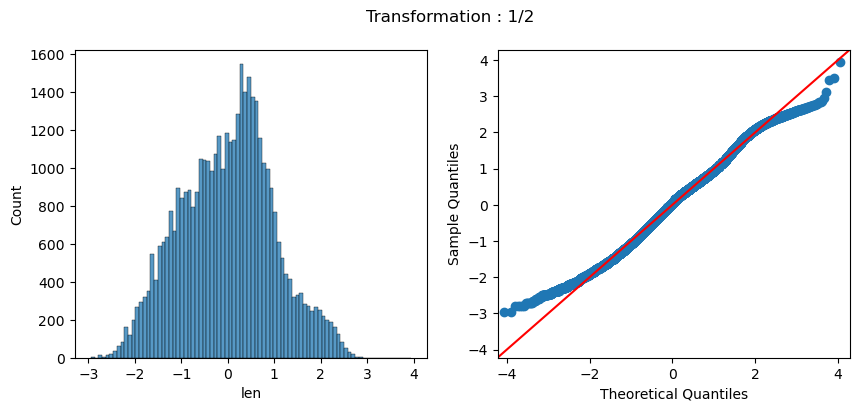

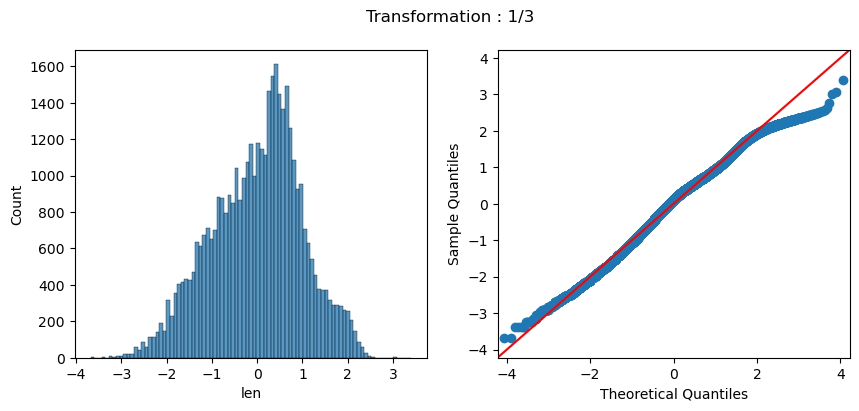

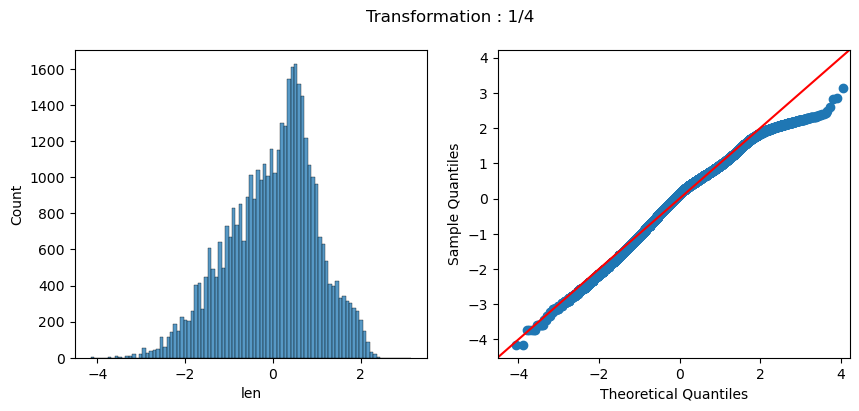

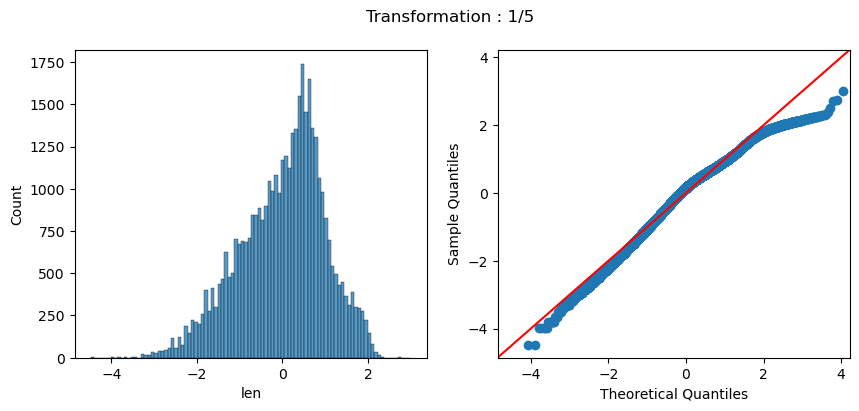

In [47]:
for i in [-2, -1, -0.5, 0, 0.5, 1, 2, 3, 4, 5]:
    fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (10, 4))
    
    if i == 0:
        transformed_len = np.log(df_tweets.len)
    else:
        transformed_len = (df_tweets.len ** (1/i))
    
    mean = transformed_len.mean()
    std = np.std(transformed_len)
    transformed_len_standardized = (transformed_len - mean) / std
    sns.histplot(transformed_len_standardized, ax = ax1)
    sm.qqplot(transformed_len_standardized, line = '45', ax = ax2)
    fig.suptitle('Transformation : 1/{}'.format(str(i)))

From the distributions & qqplots above, len raised to the power of 1/3, i.e., cube root of len looks closest to a Normal distribution.

However, not all classification algos can handle standardized data (with negative numbers, like Naive Bayes). As such, we'll have to prepare both standardized and non-standardized datasets - algos which can handle negative numbers will be applied on standardized dataset, and non-standardized dataset will be used for algos which don't allow negative numbers. Point to note, the standardization scaling is only applicable for these newly created numerical features, and not the tweets themselves (which will be handled in a separate way).

Text(0.5, 0.98, 'Transformation : 1/3, without Standardization')

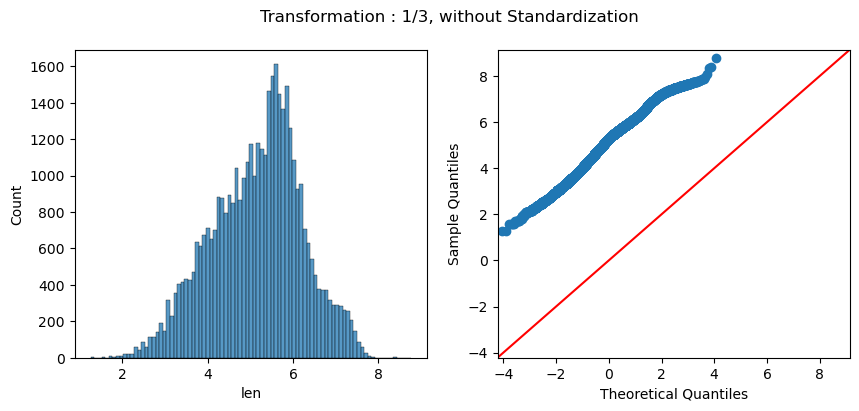

In [48]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (10, 4))
transformed_len = (df_tweets.len ** (1/3))
sns.histplot(transformed_len, ax = ax1)
sm.qqplot(transformed_len, line = '45', ax = ax2)
fig.suptitle('Transformation : 1/3, without Standardization')

# Splitting The Data & Final Preprocessing Steps
Now, let's split the data in train and test sets, before we vectorize the text, and scale/normalize the numerical features.

In [49]:
X_train, X_test, y_train, y_test = train_test_split(df_tweets.drop('isFake', axis = 1), df_tweets['isFake'],
                                                    stratify = df_tweets['isFake'], test_size = 0.15, random_state = 73)
X_train.head()

,tweet,tokens,len,tok_pct,stp_pct,tok_cnt
6872,"the air defense stadium will host the olympic team's match against its zambian counterpart, in t...","[air, defense, stadium, host, olympic, team, match, zambian, counterpart, first, leg, third, fin...",191,59.685864,23.036649,18
28139,the first half of the ghazl el mahalla match against pharco ended in a goalless draw in the matc...,"[first, half, ghazl, el, mahalla, match, pharco, ended, goalless, draw, match, brought, together...",221,63.348416,19.457014,24
620,history will witness that the day kahraououb gets a hat-trick\nzamalek gets the african hat-tric...,"[history, witness, day, kahraououb, get, hat, trick, zamalek, get, african, hat, trick, title, t...",128,62.500000,18.750000,16
6850,the al-ahly football club is considering withdrawing from the idea of playing the postponed inte...,"[al, ahly, football, club, considering, withdrawing, idea, playing, postponed, internal, confron...",167,68.263473,17.365269,16
7066,urgent: nebosha submits his resignation from coaching zamalek,"[urgent, nebosha, submits, resignation, coaching, zamalek]",60,76.666667,11.666667,6


#### Preparing Standardized Sets for The Numerical Features

In [50]:
# len, train
cuberoot_transformed_len_train = (X_train.len ** (1/3))
train_mean = cuberoot_transformed_len_train.mean()
train_std = np.std(cuberoot_transformed_len_train)
X_train['len_standardized'] = (cuberoot_transformed_len_train - train_mean) / train_std

# len, test
cuberoot_transformed_len_test = (X_test.len ** (1/3))
X_test['len_standardized'] = (cuberoot_transformed_len_test - train_mean) / train_std

# tok_pct, stp_pct
mm_scaler_standardized = MinMaxScaler(feature_range = (-3, 3))
# since len_standardized values are mostly within that range, as seen in the box-cox tryout
X_train[['tok_pct_stdscaled', 'stp_pct_stdscaled']] = mm_scaler_standardized.\
                                                                        fit_transform(X_train[['tok_pct', 'stp_pct']])
X_test[['tok_pct_stdscaled', 'stp_pct_stdscaled']] = mm_scaler_standardized.transform(X_test[['tok_pct', 'stp_pct']])
numerical_features_standardized = ['len_standardized', 'tok_pct_stdscaled', 'stp_pct_stdscaled']
X_train.head()

,tweet,tokens,len,tok_pct,stp_pct,tok_cnt,len_standardized,tok_pct_stdscaled,stp_pct_stdscaled
6872,"the air defense stadium will host the olympic team's match against its zambian counterpart, in t...","[air, defense, stadium, host, olympic, team, match, zambian, counterpart, first, leg, third, fin...",191,59.685864,23.036649,18,0.563230,0.218325,-0.880628
28139,the first half of the ghazl el mahalla match against pharco ended in a goalless draw in the matc...,"[first, half, ghazl, el, mahalla, match, pharco, ended, goalless, draw, match, brought, together...",221,63.348416,19.457014,24,0.833773,0.471041,-1.209955
620,history will witness that the day kahraououb gets a hat-trick\nzamalek gets the african hat-tric...,"[history, witness, day, kahraououb, get, hat, trick, zamalek, get, african, hat, trick, title, t...",128,62.500000,18.750000,16,-0.114858,0.412500,-1.275000
6850,the al-ahly football club is considering withdrawing from the idea of playing the postponed inte...,"[al, ahly, football, club, considering, withdrawing, idea, playing, postponed, internal, confron...",167,68.263473,17.365269,16,0.325580,0.810180,-1.402395
7066,urgent: nebosha submits his resignation from coaching zamalek,"[urgent, nebosha, submits, resignation, coaching, zamalek]",60,76.666667,11.666667,6,-1.175255,1.390000,-1.926667


#### Preparing Non-Standardized, Scaled Sets for The Numerical Features

In [51]:
# len
X_train['len_cubed'] = (X_train.len ** (1/3))
X_test['len_cubed'] = (X_test.len ** (1/3))

# tok_pct, stp_pct
mm_scaler_nonstandardized = MinMaxScaler(feature_range = (2, 8))
# since len_cubed values are mostly within that range, as seen in the non-standardized cube transfer plot
X_train[['tok_pct_scaled', 'stp_pct_scaled']] = mm_scaler_nonstandardized.fit_transform(X_train[['tok_pct', 'stp_pct']])
X_test[['tok_pct_scaled', 'stp_pct_scaled']] = mm_scaler_nonstandardized.transform(X_test[['tok_pct', 'stp_pct']])
numerical_features_scaled = ['len_cubed', 'tok_pct_scaled', 'stp_pct_scaled']
X_train.head()

,tweet,tokens,len,tok_pct,stp_pct,tok_cnt,len_standardized,tok_pct_stdscaled,stp_pct_stdscaled,len_cubed,tok_pct_scaled,stp_pct_scaled
6872,"the air defense stadium will host the olympic team's match against its zambian counterpart, in t...","[air, defense, stadium, host, olympic, team, match, zambian, counterpart, first, leg, third, fin...",191,59.685864,23.036649,18,0.563230,0.218325,-0.880628,5.758965,5.218325,4.119372
28139,the first half of the ghazl el mahalla match against pharco ended in a goalless draw in the matc...,"[first, half, ghazl, el, mahalla, match, pharco, ended, goalless, draw, match, brought, together...",221,63.348416,19.457014,24,0.833773,0.471041,-1.209955,6.045944,5.471041,3.790045
620,history will witness that the day kahraououb gets a hat-trick\nzamalek gets the african hat-tric...,"[history, witness, day, kahraououb, get, hat, trick, zamalek, get, african, hat, trick, title, t...",128,62.500000,18.750000,16,-0.114858,0.412500,-1.275000,5.039684,5.412500,3.725000
6850,the al-ahly football club is considering withdrawing from the idea of playing the postponed inte...,"[al, ahly, football, club, considering, withdrawing, idea, playing, postponed, internal, confron...",167,68.263473,17.365269,16,0.325580,0.810180,-1.402395,5.506878,5.810180,3.597605
7066,urgent: nebosha submits his resignation from coaching zamalek,"[urgent, nebosha, submits, resignation, coaching, zamalek]",60,76.666667,11.666667,6,-1.175255,1.390000,-1.926667,3.914868,6.390000,3.073333


In [52]:
df_tweets.tok_cnt.describe()

count    40819.000000
mean        16.307553
std          8.576043
min          1.000000
25%         10.000000
50%         16.000000
75%         22.000000
max        153.000000
Name: tok_cnt, dtype: float64

First of all, I would restrict our word2vec model to only consider words that appear at least 10 times within the tweet corpus (to be precise, the corpus of lemmatized token derived from those tweets).

The parameter to consider here is the vector size - default value is 100.

Problem is the highest token count for a tweet is 153, if we allow all the tokens (and each token would be replaced by its vector) - to keep the number of features same across all the tweets, we would have to create a vector matrix with 15300 features. That in itself won't be such a tragedy, except that most of those would be 0 padded since at least 75% tweets contain just 22 tokens.

So, we need to make 2 choices here - highest token count, and the size of the vector.

In [53]:
print(np.percentile(df_tweets.tok_cnt, [80, 85, 90, 95, 99, 99.5]))

[23. 25. 27. 32. 40. 43.]


For token count, I would like to go with the 90th percentile, i.e., I will consider only the first 27 tokens of any tweet for vectorization. As most of the tweets have less number of tokens, they will be 0-padded.

As for vector count, although 2700 features sound much better than earlier - I would still like to limit myself to around 1000 features (plus 3 numerical derived features). So, that gives me a vector size of 38 (rounded).

In [54]:
max_tokens = 27
vector_size_per_token = 38

In [55]:
w2v_model = Word2Vec(sentences = X_train.tokens,
                     min_count = 10,
                     vector_size = vector_size_per_token,
                     seed = 73)
print(f'Model : {w2v_model}')
print(f'Length of model.wv Dictionary : {len(w2v_model.wv)}')
print(f'Words Similar to "team" : \n{w2v_model.wv.most_similar("team")}')
print(f'Words Similar to "match" : \n{w2v_model.wv.most_similar("match")}')
print(f'The Vector for "match" :\n{w2v_model.wv.get_vector("match")}')
print(w2v_model.wv.get_index('team'), w2v_model.wv.has_index_for('koustav'))

Model : Word2Vec<vocab=4327, vector_size=38, alpha=0.025>
Length of model.wv Dictionary : 4327
Words Similar to "team" : 
[('bank', 0.7080144286155701), ('friendly', 0.651668131351471), ('brazilian', 0.6196014881134033), ('micale', 0.5987520813941956), ('future', 0.5919906497001648), ('barrondo', 0.5784720182418823), ('pharco', 0.5736961960792542), ('algerian', 0.5734041333198547), ('enppi', 0.5687602758407593), ('difficulty', 0.5676514506340027)]
Words Similar to "match" : 
[('confrontation', 0.7462449073791504), ('draw', 0.6729538440704346), ('face', 0.6605880260467529), ('goalless', 0.6102127432823181), ('scheduled', 0.596540093421936), ('tied', 0.585934579372406), ('asco', 0.5713411569595337), ('askou', 0.5610929727554321), ('facing', 0.5521774291992188), ('tala', 0.5509033203125)]
The Vector for "match" :
[ 0.47540623 -1.6343156   0.28392228  0.61545545 -1.659391   -2.0373337
 -2.0052865   1.3203907  -2.5506911  -2.4823968   0.69022894  1.0867984
 -0.64062804 -0.629789    0.063863

In [56]:
def tokens2vector(tokenlist):
    embedding_vector = np.zeros(max_tokens * vector_size_per_token)
    mask_vector = np.zeros(max_tokens)
    start_position_for_next_token = 0
    token_count = 0
    for token in tokenlist:
        if(w2v_model.wv.has_index_for(token)):
            embedding_vector[start_position_for_next_token : (start_position_for_next_token + vector_size_per_token)]\
                                                    = w2v_model.wv.get_vector(token)
            mask_vector[token_count] = 1
            # print(token, vector)
            # print(f'{token} is in the vocab.')
        start_position_for_next_token += vector_size_per_token
        token_count += 1
        if (token_count == max_tokens):
            break
    final_vector = np.append(embedding_vector, mask_vector)
    return final_vector


def printvector(arr):
    mask_vector = arr[- max_tokens : ]
    embedding_vector = arr[: - max_tokens]
    list_token_vector = []
    count_zeroes = 0
    print('Embedding Vector :')
    for position in range(len(embedding_vector)):
        item = embedding_vector[position]
        if (item == 0):
            if (sum(embedding_vector[position:]) == 0):
                count_zeroes = len(embedding_vector) - position
                break
        list_token_vector.append(item)
        if (len(list_token_vector) == vector_size_per_token):
            print(list_token_vector)
            list_token_vector = []
    if (count_zeroes > 0):
        print(f'... and {count_zeroes} 0\'s after that.')
    print(f'Masking Vector : {mask_vector}')
    return
printvector(tokens2vector(['woe']))
# printvector(tokens2vector(['urgent', 'nebosha', 'submits', 'resignation', 'coaching', 'zamalek']))

Embedding Vector :
[-0.08613783121109009, 0.4447367489337921, 0.006482765078544617, -0.20407144725322723, 0.14895974099636078, -0.2519015073776245, -0.056263890117406845, -0.15594682097434998, -0.018151085823774338, -0.2514912188053131, 0.3235188126564026, -0.24280598759651184, -0.05336970463395119, -0.026555582880973816, 0.06842988729476929, 0.01587832346558571, 0.0717163234949112, -0.09845855832099915, -0.04546575993299484, 0.08938777446746826, -0.09736093878746033, 0.20859922468662262, 0.0862632542848587, 0.002204801654443145, -0.10448598116636276, -0.021310938522219658, -0.1239289864897728, -0.0649329423904419, 0.04485679790377617, -0.016015175729990005, 0.017879057675600052, 0.054211847484111786, -0.16667363047599792, 0.1382957398891449, 0.08480742573738098, -0.24465560913085938, -0.17036674916744232, 0.027543989941477776]
... and 988 0's after that.
Masking Vector : [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


In [57]:
printvector(tokens2vector(['urgent', 'nebosha', 'submits', 'resignation', 'coaching', 'zamalek']))

Embedding Vector :
[-0.21666881442070007, 0.7461813688278198, 0.012173501774668694, -0.05760388821363449, -0.11694151163101196, -0.13731378316879272, 0.11481485515832901, -0.47918441891670227, 0.5448312759399414, -0.6421791315078735, 0.7287054061889648, -0.03539527207612991, 0.04328954964876175, 0.3343639373779297, 0.1985604614019394, 0.08821440488100052, -0.5409649610519409, -0.13864971697330475, -1.097942590713501, -0.44561269879341125, -0.22722755372524261, -0.21728958189487457, 0.564879298210144, -0.062382955104112625, 0.045696649700403214, 0.349720299243927, -0.09840665757656097, 0.24685484170913696, -0.12868346273899078, -0.41670796275138855, -0.17161524295806885, -0.1722833514213562, 0.6969115138053894, 0.8632073998451233, 0.13859404623508453, 0.6476629972457886, -0.18177562952041626, -0.2857358157634735]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [58]:
word2vec_sparse_matrix_train = sparse.csr_matrix((X_train.tokens.apply(tokens2vector)).values.tolist())
word2vec_sparse_matrix_test = sparse.csr_matrix((X_test.tokens.apply(tokens2vector)).values.tolist())

In [59]:
# does the row counts match?
print(word2vec_sparse_matrix_train.shape, # shape of sparse matrix
      X_train[numerical_features_standardized].shape, # shape of newly created & standardized numerical features
      X_train[numerical_features_scaled].shape) # shape of newly created & non-standardized numerical features
print(word2vec_sparse_matrix_test.shape,
      X_test[numerical_features_standardized].shape,
      X_test[numerical_features_scaled].shape)

(34696, 1053) (34696, 3) (34696, 3)
(6123, 1053) (6123, 3) (6123, 3)


In [60]:
# sparse matrix of standardized features
X_train_num_features_std_sparse = sparse.csr_matrix(X_train[numerical_features_standardized].values)
X_test_num_features_std_sparse = sparse.csr_matrix(X_test[numerical_features_standardized].values)

X_train_sparse_std = sparse.hstack((X_train_num_features_std_sparse, word2vec_sparse_matrix_train))
X_test_sparse_std = sparse.hstack((X_test_num_features_std_sparse, word2vec_sparse_matrix_test))

# sparse matrix of scaled features
X_train_num_features_scaled_sparse = sparse.csr_matrix(X_train[numerical_features_scaled].values)
X_test_num_features_scaled_sparse = sparse.csr_matrix(X_test[numerical_features_scaled].values)

X_train_sparse_scaled = sparse.hstack((X_train_num_features_scaled_sparse, word2vec_sparse_matrix_train))
X_test_sparse_scaled = sparse.hstack((X_test_num_features_scaled_sparse, word2vec_sparse_matrix_test))

print('Shapes of Standardized Train & Test sets respectively : {}, {}.'.format(X_train_sparse_std.shape,
                                                                               X_test_sparse_std.shape))
print('Shapes of Scaled Train & Test sets respectively : {}, {}.'.format(X_train_sparse_scaled.shape,
                                                                         X_test_sparse_scaled.shape))

Shapes of Standardized Train & Test sets respectively : (34696, 1056), (6123, 1056).
Shapes of Scaled Train & Test sets respectively : (34696, 1056), (6123, 1056).


# Saving The Preprocessed Data
We are finally ready with the dataset to be fed to various classification algos. Let's save the data here, and we'll use the same 

In [61]:
# Standardized Dataset
np.savez(
    file = output_datapath / 'PreprocessedData_Standardized_wMask', # file name
    # to save/load sparse data to/from npz, we need data, indices, indptr, shape
    X_train_data = X_train_sparse_std.data, # X_train_sparse_std
    X_train_indices = X_train_sparse_std.indices,
    X_train_indptr = X_train_sparse_std.indptr,
    X_train_shape = X_train_sparse_std.shape,
    y_train = y_train, # y_train
    X_test_data = X_test_sparse_std.data, # X_test_sparse_std
    X_test_indices = X_test_sparse_std.indices,
    X_test_indptr = X_test_sparse_std.indptr,
    X_test_shape = X_test_sparse_std.shape,
    y_test = y_test # y_test
)

# Non-Standardized, Scaled Dataset
np.savez(
    file = output_datapath / 'PreprocessedData_Scaled_wMask',
    X_train_data = X_train_sparse_scaled.data, # X_train_sparse_scaled
    X_train_indices = X_train_sparse_scaled.indices,
    X_train_indptr = X_train_sparse_scaled.indptr,
    X_train_shape = X_train_sparse_scaled.shape,
    y_train = y_train, # y_train
    X_test_data = X_test_sparse_scaled.data, # X_test_sparse
    X_test_indices = X_test_sparse_scaled.indices,
    X_test_indptr = X_test_sparse_scaled.indptr,
    X_test_shape = X_test_sparse_scaled.shape,
    y_test = y_test # y_test
)